In [ ]:
#Empiezo instalando los paquetes
!pip install tensorflow keras numpy pandas matplotlib opencv-python scikit-learn
import tensorflow as tf

In [ ]:
#Elimino las imágenes de mala calidad o inapropiadas que puedan afectar el rendimiento del modelo, estoy usando el dataset FER2013
#Os
import os
#Python libraries
import imghdr
#Others
import cv2
data_dir = 'drive/MyDrive/ColabNotebooks/train'
image_ext = ['jpg','jpeg']
#This will iterate the data in the directory
for emotion_dir in os.listdir(data_dir):
  for emotion_img in os.listdir(os.path.join(data_dir, emotion_dir)):
    emotion_path = os.path.join(data_dir,emotion_dir, emotion_img)
    try:
      #It loads the image
      #It checks the extension of the image
      imag = cv2.imread(emotion_path)
      ext = imghdr.what(emotion_path)
      if ext not in image_ext:
        print('Image is not in {}'.format(emotion_path))
        os.remove(emotion_path)
    except Exception as e:
      print('Issue with image {}. Error: {}'.format(emotion_path, e))

In [ ]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [ ]:
import numpy as np
from matplotlib import pyplot as plt


#it loads the dataset to have the classes
data = tf.keras.utils.image_dataset_from_directory('drive/MyDrive/ColabNotebooks/train')
#Convert the data in numpy format
data_iterator = data.as_numpy_iterator()
#I create a batch to train the model, It's a tuple, first the image and second the class or label
batch = data_iterator.next()


Found 638 files belonging to 4 classes.


In [ ]:
"""
This is for seeing the images I am using to train the model.
"""
#Create a figure and it will have other 4 in a row. ax will be the variable for the 4 images and each figure will have a size od 20,20
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
#It will iterate the first 4 images of the batch, and enumerate returns the index with value (imag).
for idx, img in enumerate(batch[0][:4]):
  #It shows the current image and the values of the pixels was turned into integers.
  ax[idx].imshow(img.astype(int))
  #The title for the 4 figures each one will be depending of batch[1], it has the label.
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
#It divided each pixel by 255, and now the scale is instead of 0-255 is 0-1.
data = data.map(lambda x,y:(x/255,y))
#I will get the next batch of images
data.as_numpy_iterator().next()

In [ ]:
#It will be 70% for training, 20% for validating and 10% for testing
training_size = int(len(data)*.7)
validation_size = int(len(data)*0.2)
testing_size = int(len(data)*0.1)

In [ ]:
#It will take the set of training_size images to train the model
training = data.take(training_size)
#It will skip the set of training_size and it will take the validation_size to validate the model
validating = data.skip(training_size).take(validation_size)
#It will skip training_size and validation_size and it will take testing_size
testing = data.skip(training_size+validation_size).take(testing_size)

In [ ]:
#I will use convolutional neuronal networl (CNN)
#Sequential to create models
from tensorflow.keras.models import Sequential

#This classes for using it in the model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam

#Instance of the class Sequential
model = Sequential()

#Create a layer of Conv2D with 16 filters with a size of 3x3,
#activation type relu and the details of the image
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#It will reduce the dimensionality of the input
model.add(MaxPooling2D())
model.add(Dropout(0.30))
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
#It will flatten the matrix 2D to 1D
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [ ]:
optimizer=Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
#The summary of my model
model.summary()

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
#Training the model
hist = model.fit(training, epochs=20, validation_data=validating, callbacks=[tensorboard_callback])

Epoch 1/20
14/14 [==============================] - 18s 1s/step - loss: 0.2498 - accuracy: 0.9219 - val_loss: 0.4472 - val_accuracy: 0.8594
Epoch 2/20
14/14 [==============================] - 19s 1s/step - loss: 0.1999 - accuracy: 0.9219 - val_loss: 0.3488 - val_accuracy: 0.8516
Epoch 3/20
14/14 [==============================] - 17s 1s/step - loss: 0.1848 - accuracy: 0.9420 - val_loss: 0.2626 - val_accuracy: 0.9219
Epoch 4/20
14/14 [==============================] - 18s 1s/step - loss: 0.1532 - accuracy: 0.9509 - val_loss: 0.2168 - val_accuracy: 0.9453
Epoch 5/20
14/14 [==============================] - 18s 1s/step - loss: 0.1220 - accuracy: 0.9554 - val_loss: 0.2290 - val_accuracy: 0.9375
Epoch 6/20
14/14 [==============================] - 19s 1s/step - loss: 0.1167 - accuracy: 0.9554 - val_loss: 0.1285 - val_accuracy: 0.9766
Epoch 7/20
14/14 [==============================] - 18s 1s/step - loss: 0.1032 - accuracy: 0.9621 - val_loss: 0.2226 - val_accuracy: 0.9609
Epoch 8/20
14/14 [==

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal',label='loss')
plt.plot(hist.history['val_loss'], color='orange',label='val_loss')
fig.suptitle('Loss', fontsize=10)
plt.legend(loc="upper left")
plt.show

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.utils import to_categorical

In [ ]:
pre = Precision()
re = Recall()
acc = SparseCategoricalAccuracy()

In [ ]:
for batch in testing.as_numpy_iterator():
  x, y_true = batch
  y_pred = model.predict(x)
  y_true_one_hot = to_categorical(y_true, num_classes=4)

  pre.update_state(y_true_one_hot, y_pred)
  re.update_state(y_true_one_hot, y_pred)
  acc.update_state(y_true, y_pred)

1/1 [==============================] - 0s 441ms/step


In [ ]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0,Accuracy:1.0


<function matplotlib.pyplot.show(close=None, block=None)>

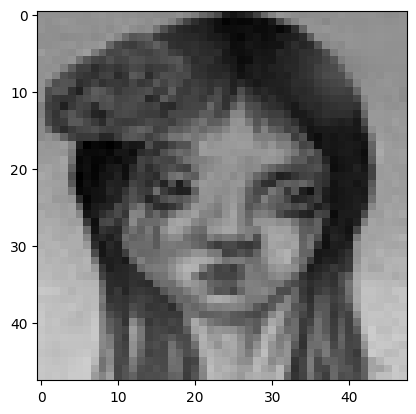

In [ ]:
img = cv2.imread('drive/MyDrive/ColabNotebooks/train/sad/Training_1121862.jpg')
plt.imshow(img)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

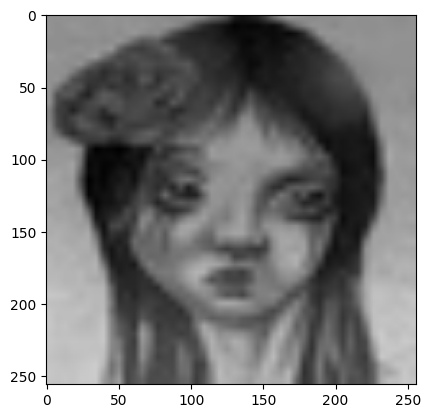

In [ ]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show

In [ ]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 29ms/step


In [ ]:
yhat

array([[2.7238909e-06, 1.1594783e-03, 9.9883777e-01, 9.1943092e-11]],
      dtype=float32)

In [ ]:
clases = ['Angry','Happy','Sad','Surprise']
prediccion = np.argmax(yhat)
print(f'La predicción es {clases[prediccion]}')

La predicción es Sad


In [291]:
from tensorflow.keras.models import load_model
model.save(os.path.join('drive/MyDrive/ColabNotebooks','Arkangeltest.h5'))
new_model = load_model('drive/MyDrive/ColabNotebooks/Arkangeltest.h5')
new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 77ms/step


array([[2.7238909e-06, 1.1594783e-03, 9.9883777e-01, 9.1943092e-11]],
      dtype=float32)

In [296]:
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
model = load_model('drive/MyDrive/ColabNotebooks/Arkangeltest.h5')
imagen = Image.open('drive/MyDrive/ColabNotebooks/train/happy/Training_1065829.jpg')
imagen = imagen.resize((256,256))
if imagen.mode != 'RGB':
  imagen = imagen.convert('RGB')
imagen = img_to_array(imagen) / 255.0
imagen = np.expand_dims(imagen, axis=0)
prediccion = model.predict(imagen)
print(prediccion)


1/1 [==============================] - 0s 113ms/step
[[4.0528775e-04 9.9934775e-01 2.4679920e-04 1.0443216e-07]]
